## Normalizing flow
Loading data - CIFAR10 dataset. Using included read function.  
Source http://www.cs.toronto.edu/~kriz/cifar.html.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.stats import kde

import cv2

import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import tensorflow_probability as tfp
import sonnet as snt
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
tfb = tfp.bijectors
tfd = tfp.distributions

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
d=unpickle('../data/data_batch_1')
x = d[b'data'].reshape([-1,3,32,32])
y = d[b'labels']

x = np.moveaxis(x,[1],[3])

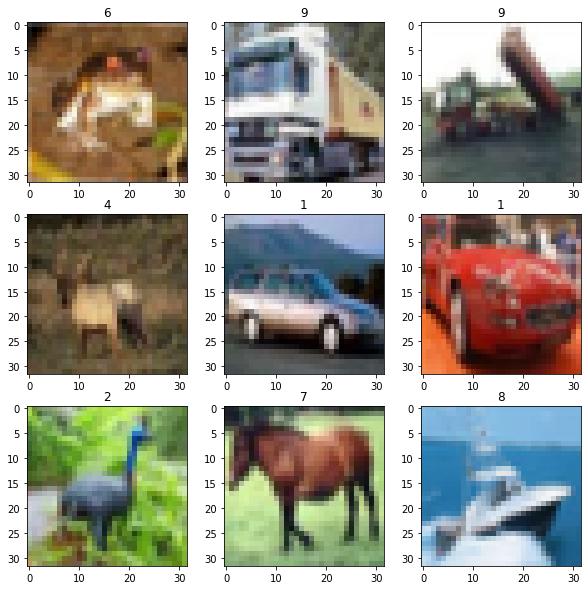

In [4]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(10,10)
for i,j in enumerate(axs.flatten()):
    j.imshow(x[i])
    j.set_title(y[i])

In [5]:
gray_x = np.empty(x.shape[:-1])
gray_x = np.expand_dims(gray_x, axis=-1)

for i in range(0,x.shape[0],1000):
    gray_x[i:i+1000] = tf.image.rgb_to_grayscale(x[i:i+1000])
    
gray_x = gray_x.astype(np.float32)

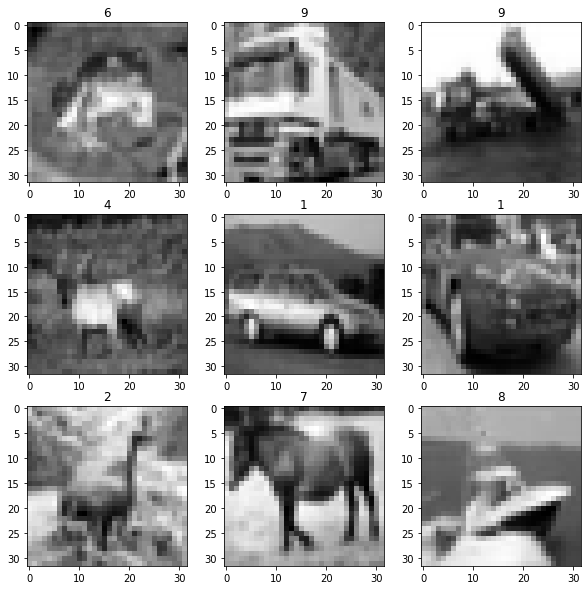

In [6]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(10,10)
for i,j in enumerate(axs.flatten()):
    j.imshow(gray_x[i],'gray')
    j.set_title(y[i])

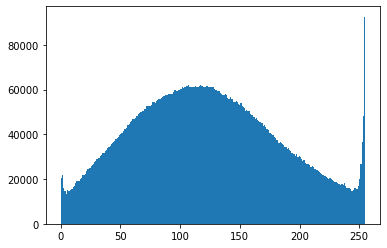

In [7]:
plt.hist(gray_x.flatten(),bins=256)
plt.show()

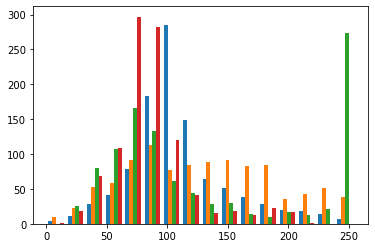

In [8]:
plt.hist(gray_x.reshape([gray_x.shape[0],-1])[:4].T,bins=16)
plt.show()

In [9]:
base_loc = np.array([0.0]).astype(np.float32)
base_sigma = np.array([0.8]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)

In [10]:
class MLP_ODE(snt.Module):
  """Multi-layer NN ode_fn."""
  def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
    super(MLP_ODE, self).__init__(name=name)
    self._num_hidden = num_hidden
    self._num_output = num_output
    self._num_layers = num_layers
    self._modules = []
    for _ in range(self._num_layers - 1):
      self._modules.append(snt.Linear(self._num_hidden))
      self._modules.append(tf.math.tanh)
    self._modules.append(snt.Linear(self._num_output))
    self._model = snt.Sequential(self._modules)

  def __call__(self, t, inputs):
    inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
    return self._model(inputs)

In [11]:
LR = 1e-2 
NUM_EPOCHS = 10
STACKED_FFJORDS = 4 
NUM_HIDDEN = 8 
NUM_LAYERS = 3 
NUM_OUTPUT = 1
DATASET_SIZE = 1024 * 8 
BATCH_SIZE = 16 
SAMPLE_SIZE = DATASET_SIZE

In [12]:
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact

bijectors = []
for _ in range(STACKED_FFJORDS):
  mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
  next_ffjord = tfb.FFJORD(
      state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
      trace_augmentation_fn=trace_augmentation_fn)
  bijectors.append(next_ffjord)

stacked_ffjord = tfb.Chain(bijectors[::-1])

In [13]:
transformed_distribution = tfd.TransformedDistribution(
    distribution=base_distribution, bijector=stacked_ffjord)

In [14]:
@tf.function
def train_step(optimizer, target_sample):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
  variables = tape.watched_variables()
  gradients = tape.gradient(loss, variables)
  optimizer.apply(gradients, variables)
  return loss

In [15]:
@tf.function
def get_samples():
  base_distribution_samples = base_distribution.sample(SAMPLE_SIZE)
  transformed_samples = transformed_distribution.sample(SAMPLE_SIZE)
  return base_distribution_samples, transformed_samples


@tf.function
def get_transformed_grid():
  transformed_grid = stacked_ffjord.forward(grid)
  return transformed_grid

In [16]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)
for epoch_num in range(NUM_EPOCHS):
    print(f"Epoch: {epoch_num}")
    for i in tqdm.tqdm(range(0,gray_x.shape[0],BATCH_SIZE)):
        batch = gray_x[i:i+BATCH_SIZE].reshape([-1,1])
        _ = train_step(optimizer, batch)
    

Epoch: 0


  0%|                                                   | 0/625 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|█████████████████████████████████████████| 625/625 [04:33<00:00,  2.29it/s]


Epoch: 1


100%|█████████████████████████████████████████| 625/625 [05:05<00:00,  2.04it/s]


Epoch: 2


100%|█████████████████████████████████████████| 625/625 [05:19<00:00,  1.95it/s]


Epoch: 3


100%|█████████████████████████████████████████| 625/625 [05:34<00:00,  1.87it/s]


Epoch: 4


100%|█████████████████████████████████████████| 625/625 [05:35<00:00,  1.87it/s]


Epoch: 5


100%|█████████████████████████████████████████| 625/625 [05:25<00:00,  1.92it/s]


Epoch: 6


100%|█████████████████████████████████████████| 625/625 [05:41<00:00,  1.83it/s]


Epoch: 7


100%|█████████████████████████████████████████| 625/625 [06:02<00:00,  1.72it/s]


Epoch: 8


100%|█████████████████████████████████████████| 625/625 [06:32<00:00,  1.59it/s]


Epoch: 9


100%|█████████████████████████████████████████| 625/625 [06:28<00:00,  1.61it/s]


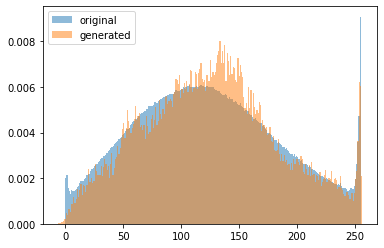

In [17]:
plt.hist(gray_x.flatten(),bins=256,label='original',density=True,alpha=0.5)
plt.hist(transformed_distribution.sample(38000).numpy().flatten(),label='generated',bins=256,density=True,alpha=0.5)
plt.legend()
plt.show()

In [18]:
transformed_distribution.sample(32000).numpy().flatten()

array([ 97.86644,  98.79277, 184.45107, ...,  64.07785, 186.38634,
        49.94812], dtype=float32)

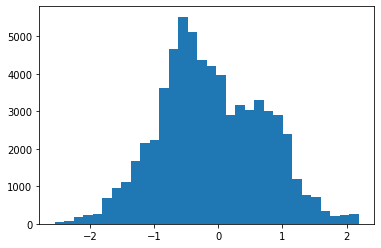

In [19]:
plt.hist(stacked_ffjord.inverse(gray_x[:64].reshape([-1,1])).numpy(),bins=32)
plt.show()

In [20]:
import h5py

In [22]:
nf_x = np.empty(gray_x.shape)

for i in range(gray_x.shape[0]):
    print(f"{i}/{gray_x.shape[0]}|",end='\r')
    nf_x[i] = stacked_ffjord.inverse(gray_x[i].reshape([-1,1])).numpy().reshape([32,32,1])

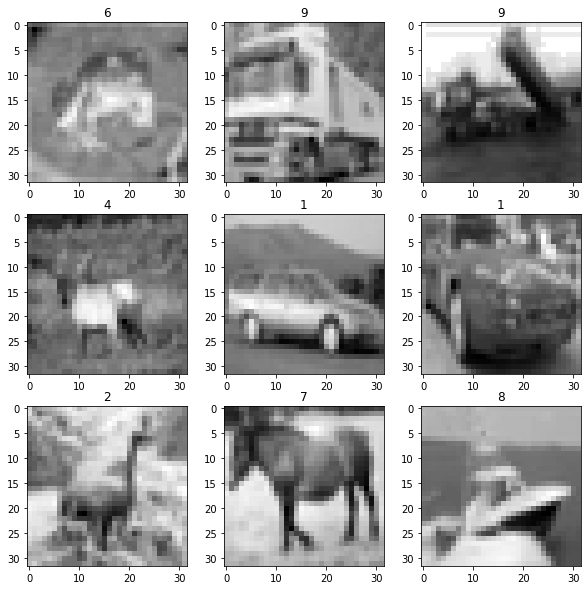

In [23]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(10,10)
for i,j in enumerate(axs.flatten()):
    j.imshow(nf_x[i],'gray')
    j.set_title(y[i])

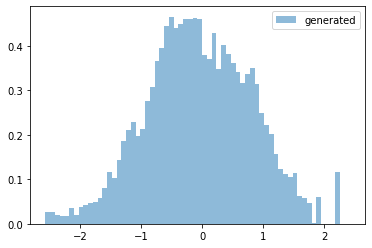

In [24]:
plt.hist(nf_x.flatten(),label='generated',bins=64,density=True,alpha=0.5)
plt.legend()
plt.show()

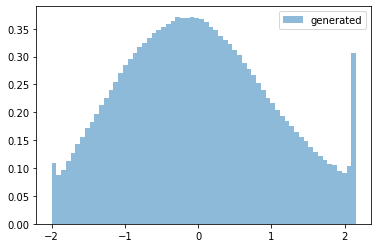

In [25]:
plt.hist(((gray_x-gray_x.mean())/gray_x.std()).flatten(),label='generated',bins=64,density=True,alpha=0.5)
plt.legend()
plt.show()

In [26]:
h5f = h5py.File('../data/nf_x.h5', 'w')
h5f.create_dataset('nf_x', data=nf_x)
h5f.create_dataset('y', data=y)
h5f.close()

In [27]:
h5f = h5py.File('../data/gray_x.h5', 'w')
h5f.create_dataset('gray_x', data=gray_x/255)
h5f.create_dataset('y', data=y)
h5f.close()

In [28]:
h5f = h5py.File('../data/norm_gray_x.h5', 'w')
h5f.create_dataset('norm_gray_x', data=(gray_x-gray_x.mean())/gray_x.std())
h5f.create_dataset('y', data=y)
h5f.close()

In [29]:
del gray_x, x, y, nf_x

In [30]:
d=unpickle('../data/test_batch')
x_t = d[b'data'].reshape([-1,3,32,32])
y_t = d[b'labels']

x_t = np.moveaxis(x_t,[1],[3])

In [31]:
gray_x_t = np.empty(x_t.shape[:-1])
gray_x_t = np.expand_dims(gray_x_t, axis=-1)

for i in range(0,x_t.shape[0],1000):
    gray_x_t[i:i+1000] = tf.image.rgb_to_grayscale(x_t[i:i+1000])
    
gray_x_t = gray_x_t.astype(np.float32)

In [32]:
nf_x_t = np.empty(gray_x_t.shape)

for i in range(gray_x_t.shape[0]):
    print(f"{i}/{gray_x_t.shape[0]}|",end='\r')
    nf_x_t[i] = stacked_ffjord.inverse(gray_x_t[i].reshape([-1,1])).numpy().reshape([32,32,1])
#for i in range(0,gray_x_t.shape[0],64):
#    print(f"{i}/{gray_x_t.shape[0]}|",end='\r')
#    nf_x_t[i:i+64] = stacked_ffjord.inverse(gray_x_t[i].reshape([-1,1024,1])).numpy().reshape([-1,32,32,1])

In [33]:
h5f = h5py.File('../data/nf_x_t.h5', 'w')
h5f.create_dataset('nf_x_t', data=nf_x_t)
h5f.create_dataset('y_t', data=y_t)
h5f.close()

In [34]:
h5f = h5py.File('../data/gray_x_t.h5', 'w')
h5f.create_dataset('gray_x_t', data=gray_x_t/255)
h5f.create_dataset('y_t', data=y_t)
h5f.close()

In [35]:
h5f = h5py.File('../data/norm_gray_x_t.h5', 'w')
h5f.create_dataset('norm_gray_x_t', data=(gray_x_t-gray_x_t.mean())/gray_x_t.std())
h5f.create_dataset('y_t', data=y_t)
h5f.close()